In [19]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
import pytz
from pandas.tseries.holiday import USFederalHolidayCalendar

try: import setGPU
except ImportError: pass
import warnings
import torch

import model_classes, nets
from constants import *

from model_classes import SolvePointQP

from data import get_data, get_decision_mask, get_decision_mask_

%load_ext autoreload
%autoreload 2

warnings.simplefilter("ignore")

DEVICE = "cpu"
if torch.cuda.is_available(): 
    DEVICE = "cuda"
print("DEVICE", DEVICE, "hi")

X_train, Y_train, X_test, Y_test, X_train_pt, Y_train_pt, X_test_pt, Y_test_pt = get_data(DEVICE) 
variables = {'X_train_': X_train_pt, 'Y_train_': Y_train_pt, 
        'X_test_': X_test_pt, 'Y_test_': Y_test_pt}

params = {"n": 24, "c_ramp": 0.4, "gamma_under": 50, "gamma_over": 0.5}

mask = get_decision_mask(Y_train_pt, DEVICE)

EPOCHS_rmse = 200

print("TRAINING 2-STAGE")
model_rmse = model_classes.Net(X_train[:,:-1], Y_train, [200, 200]).to(DEVICE)
model_rmse = nets.run_rmse_net(model_rmse, variables, X_train, Y_train, EPOCHS_rmse)
model_rmse.eval()

EPOCHS_e2e = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DEVICE cuda hi
TRAINING 2-STAGE


In [20]:
print("TRAINING END-to-END")
end_to_end_net = nets.train_end_to_end(X_train[:,:-1], Y_train, variables, params, 400, DEVICE)
end_to_end_net.eval()

TRAINING END-to-END
epoch: 0   6.769690632820129
epoch: 40   0.5236739993095398
epoch: 80   0.5909971594810486
epoch: 120   0.5611312359571456
epoch: 160   0.40533834099769595
epoch: 200   0.4636148244142532
epoch: 240   0.4443850010633469
epoch: 280   0.4066182315349579
epoch: 320   0.3909959703683853
epoch: 360   0.39957232475280763


Net(
  (lin): Linear(in_features=149, out_features=24, bias=True)
  (net): Sequential(
    (0): Linear(in_features=149, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=200, out_features=24, bias=True)
  )
)

In [ ]:
print("TRAIN P-MODEL")
p_net = nets.train_pnet(end_to_end_net, X_train_pt, Y_train_pt, params, 4000, DEVICE)
p_net.eval();

TRAIN P-MODEL
epoch: 0   0.511872410774231
epoch: 400   0.32661674737930296
epoch: 800   0.30034556701779364
epoch: 1200   0.2707848769426346
epoch: 1600   0.24867946818470954
epoch: 2800   0.1882987316697836
epoch: 3200   0.16939189314842223
epoch: 3600   0.1628490522503853


In [73]:
print("TRAIN F-MODEL")
# f_net = model_classes.FNet(X_train[:,:-1], Y_train, [200, 200]).to(DEVICE)
f_net = nets.train_fnet(f_net, p_net, X_train[:,:-1], Y_train, variables, params, 2000, DEVICE)

end_to_end_net.eval()
f_net.eval()

TRAIN F-MODEL
epoch: 0   0.007396284035516705
epoch: 20   0.010016845452046255
epoch: 40   0.007578555873478763
epoch: 60   0.005226198412710801
epoch: 80   0.01382506194000598
epoch: 100   0.013783356429048581
epoch: 120   0.005495912469632458
epoch: 140   0.02018836655828636
epoch: 160   0.016953749457607047
epoch: 180   0.043102673412649894
epoch: 200   0.017609268498927123
epoch: 220   0.003214236273634015


KeyboardInterrupt: 

In [61]:
reward_learner = nets.train_reward_learner(p_net, X_train[:,:-1], Y_train, variables, params, 1000, DEVICE)

0 0.37904945503060633
10 0.1666721010580659
20 0.10774160077795386
30 0.08732015214860439
40 0.08037764225155115
50 0.07287448558956384
60 0.058051897641271354
70 0.05868791427463293
80 0.043537204740569
90 0.04002793658524752
100 0.03769151662476361
110 0.03584921695291996
120 0.038328109914436935
130 0.029232106702402234
140 0.029866836224682627
150 0.0275243269931525
160 0.024751224191859364
170 0.02148118390701711
180 0.021840772866271438
190 0.019339186213910578
200 0.01759004408493638
210 0.020227278242819013
220 0.01619431809987873
230 0.01649337255395949
240 0.01693031017202884
250 0.018659305232577025
260 0.016682366773020475
270 0.011060677776113153
280 0.013782857262995094
290 0.011482022271957248
300 0.017989160467404872
310 0.012599993664771318
320 0.013106906418688596
330 0.012264792810892686
340 0.010926641456317157
350 0.011108917152741924
360 0.010666093821637333
370 0.0117803892318625
380 0.009901738472981378
390 0.01126640640082769
400 0.010811554404208437
410 0.0106

In [62]:
all_rewards = []
for w in range(24):
    r = reward_learner(X_test_pt, w).cpu().detach()
    all_rewards.append(list(r))
reward_losses = []
# print(reward_actions.shape)
all_rewards = np.array(all_rewards)
reward_actions = np.argmin(all_rewards, axis=0)
print(all_rewards.shape)
print(reward_actions.shape)

(24, 639)
(639,)


In [63]:
def task_loss_no_mean(Y_sched, Y_actual, params):
    return (params["gamma_under"] * torch.clamp(Y_actual - Y_sched, min=0) + 
        params["gamma_over"] * torch.clamp(Y_sched - Y_actual, min=0))

def pred_obj(x, w): 
    f_pred = f_net(x, w)
    m = get_decision_mask_(f_pred, DEVICE, w)

    p_pred = p_net(x, f_pred, m)

    v2 = p_pred[:,w:]
    v1 = p_net(x, torch.zeros_like(f_pred), torch.zeros_like(f_pred))[:,:w]

    v = torch.cat((v1, v2), 1)

    loss = nets.task_loss(v, f_pred, params).mean()
    return loss.item()


def eval_decision(x, y, w):
    f_pred = f_net(x, w)
    m = get_decision_mask_(y, DEVICE, w)

    p_pred = p_net(x, y, m)
    
    v1 = p_net(x, y, torch.zeros_like(y))[:,:w]
    # v1 = f_pred[:,:w]
    v2 = p_pred[:,w:]
            
    v = torch.cat((v1, v2), 1)

    loss = nets.task_loss(v, y, params).mean()
    return loss.item()

In [74]:
vanilla = [] 
ours = [] 
random = []
optimal = []
two_stage = []
all_costs = []
end_to_end_net.eval()
f_net.eval()
p_net.eval()
reward_losses = []

my_decisions = []


for indx in range(len(X_test_pt)):
# for indx in [2]:
    X_t = X_test_pt[indx:indx+1,:]
    Y_t = Y_test_pt[indx:indx+1,:]
    # X_t = X_train_pt[indx:indx+1,:]
    # Y_t = Y_train_pt[indx:indx+1,:]

    # e2e = nets.task_loss(end_to_end_net.predict(X_t), Y_t, params).mean().item()
    e2e_pred = p_net(X_t, torch.zeros_like(Y_t), torch.zeros_like(Y_t))
    e2e = nets.task_loss(e2e_pred, Y_t, params).mean().item() 

    ts = nets.task_loss(model_rmse(X_t), Y_t, params).mean().item()
    
    print("end-to-end cost:", e2e)
    print("2-stage    cost:", ts)

    a = 0.0
    best_cost = 1e5 
    best_w = -1
    cur_costs = [] 
    for w in range(24):
        c = pred_obj(X_t, w)
        # print(w, c)
        if c < best_cost: 
            best_cost = c
            best_w = w
            
    my_decisions.append(best_w)
    our = eval_decision(X_t, Y_t, best_w) + a*best_w

    r = np.random.randint(24)
    rand = eval_decision(X_t, Y_t, r) + a*r
    
    print("TRUE")
    best_cost = 1e5 
    best_dec = -1
    uniform_random = 0
    for w in range(24): 
        cur = eval_decision(X_t, Y_t, w) + a*w
        # print(w, cur)
        if cur < best_cost: 
            best_cost = cur 
            best_dec = w
        uniform_random += cur
        cur_costs.append(cur)
    all_costs.append(cur_costs)
    
    reward_loss = eval_decision(X_t, Y_t, reward_actions[indx]) 
    reward_losses.append(reward_loss)
    
    # if best_dec == 0: continue 
    
    optimal.append(best_cost)
    vanilla.append(e2e)    
    ours.append(our)
    random.append(uniform_random/24)
    two_stage.append(ts)
    
    print("CHOSEN  true cost:", best_w, our)
    print("RANDOM  true cost: ", -1, uniform_random/24)
    print("OPTIMAL true cost:", best_dec, best_cost)
    print("REWARD  true cost:", reward_actions[indx], reward_loss)
    print()


end-to-end cost: 0.2939223647117615
2-stage    cost: 0.27221572399139404
TRUE
CHOSEN  true cost: 3 0.19708868861198425
RANDOM  true cost:  -1 0.22479579908152422
OPTIMAL true cost: 2 0.19170646369457245
REWARD  true cost: 17 0.21494679152965546

end-to-end cost: 0.2630069851875305
2-stage    cost: 0.20238268375396729
TRUE
CHOSEN  true cost: 16 0.18894803524017334
RANDOM  true cost:  -1 0.21338509333630404
OPTIMAL true cost: 16 0.18894803524017334
REWARD  true cost: 7 0.2043449878692627

end-to-end cost: 0.32557618618011475
2-stage    cost: 0.375069797039032
TRUE
CHOSEN  true cost: 6 0.26440542936325073
RANDOM  true cost:  -1 0.26823648003240425
OPTIMAL true cost: 16 0.23936347663402557
REWARD  true cost: 3 0.25782617926597595

end-to-end cost: 0.30497655272483826
2-stage    cost: 0.21156638860702515
TRUE
CHOSEN  true cost: 3 0.19463442265987396
RANDOM  true cost:  -1 0.22697151452302933
OPTIMAL true cost: 2 0.18904022872447968
REWARD  true cost: 15 0.21041059494018555

end-to-end cost:

In [90]:
# best sinle action
avg_cost_per_action = np.mean(all_costs, axis=0)
all_costs = np.array(all_costs)

single_action=1

ours = np.array(ours) 
reward_losses = np.array(reward_losses) 
vanilla = np.array(vanilla) 
random = np.array(random)
# single_action = np.argmin(avg_cost_per_action)

In [76]:
print("VANILLA e2e", np.mean(vanilla), np.std(vanilla))
print("Our app    ", np.mean(ours), np.std(ours))
print("Reward    ", np.mean(reward_losses), np.std(reward_losses))
print("random     ", np.mean(random), np.std(random))
print("optimal    ", np.mean(optimal), np.std(optimal))
print("2-s        ", np.mean(two_stage), np.std(two_stage))
print("single ac  ", avg_cost_per_action[single_action], single_action)

VANILLA e2e 0.34955737082191474 0.21092612916485454
Our app     0.23371138570594116 0.1831784826860976
Reward     0.23666919817993526 0.15589484795428954
random      0.2690549707304964 0.1398300638928127
optimal     0.19746924370107516 0.0708102836430697
2-s         1.425195986585741 1.9306447946765468
single ac   0.26670864894869556 1


In [77]:
QUANTILE = 0.5
print("VANILLA e2e  ", np.quantile(vanilla, QUANTILE), np.std(vanilla))
print("Our app      ", np.quantile(ours, QUANTILE), np.std(ours))
print("random       ", np.quantile(random, QUANTILE), np.std(random))
print("reward       ", np.quantile(reward_losses, QUANTILE), np.std(random))
print("optimal      ", np.quantile(optimal, QUANTILE), np.std(optimal))
print("single ac    ", np.quantile(all_costs[:,single_action], QUANTILE))
print("2-stage      ", np.quantile(two_stage, QUANTILE), np.std(two_stage))

VANILLA e2e   0.3502837121486664 0.21092612916485454
Our app       0.20919057726860046 0.1831784826860976
random        0.26394308047990006 0.1398300638928127
reward        0.22011375427246094 0.1398300638928127
optimal       0.19834409654140472 0.0708102836430697
single ac     0.2607725262641907
2-stage       0.5649001598358154 1.9306447946765468


In [138]:
P = 1.0

In [148]:
single = np.array(all_costs[:,single_action])

In [149]:
print(sum(np.array(ours) <= np.array(all_costs[:,single_action]) * P) / len(ours))

0.8153364632237872


In [150]:
print(sum(np.array(ours) <= np.array(random) * P) / len(ours))

0.8794992175273866


In [151]:
print(sum(np.array(ours) <= np.array(two_stage) * P) / len(ours))

0.6557120500782473


In [152]:
print(sum(np.array(ours) <= np.array(vanilla) * P) / len(ours))

0.8951486697965572


In [153]:
print(sum(np.array(ours) <= np.array(reward_losses) * P) / len(ours))

0.7089201877934272


In [154]:
np.save("ours.npy", ours)
np.save("two_stage.npy", two_stage)
np.save("reward_losses.npy", reward_losses)
np.save("vanilla.npy", vanilla)
np.save("random.npy", random)
np.save("single.npy", single)

In [147]:
print("HI")

HI


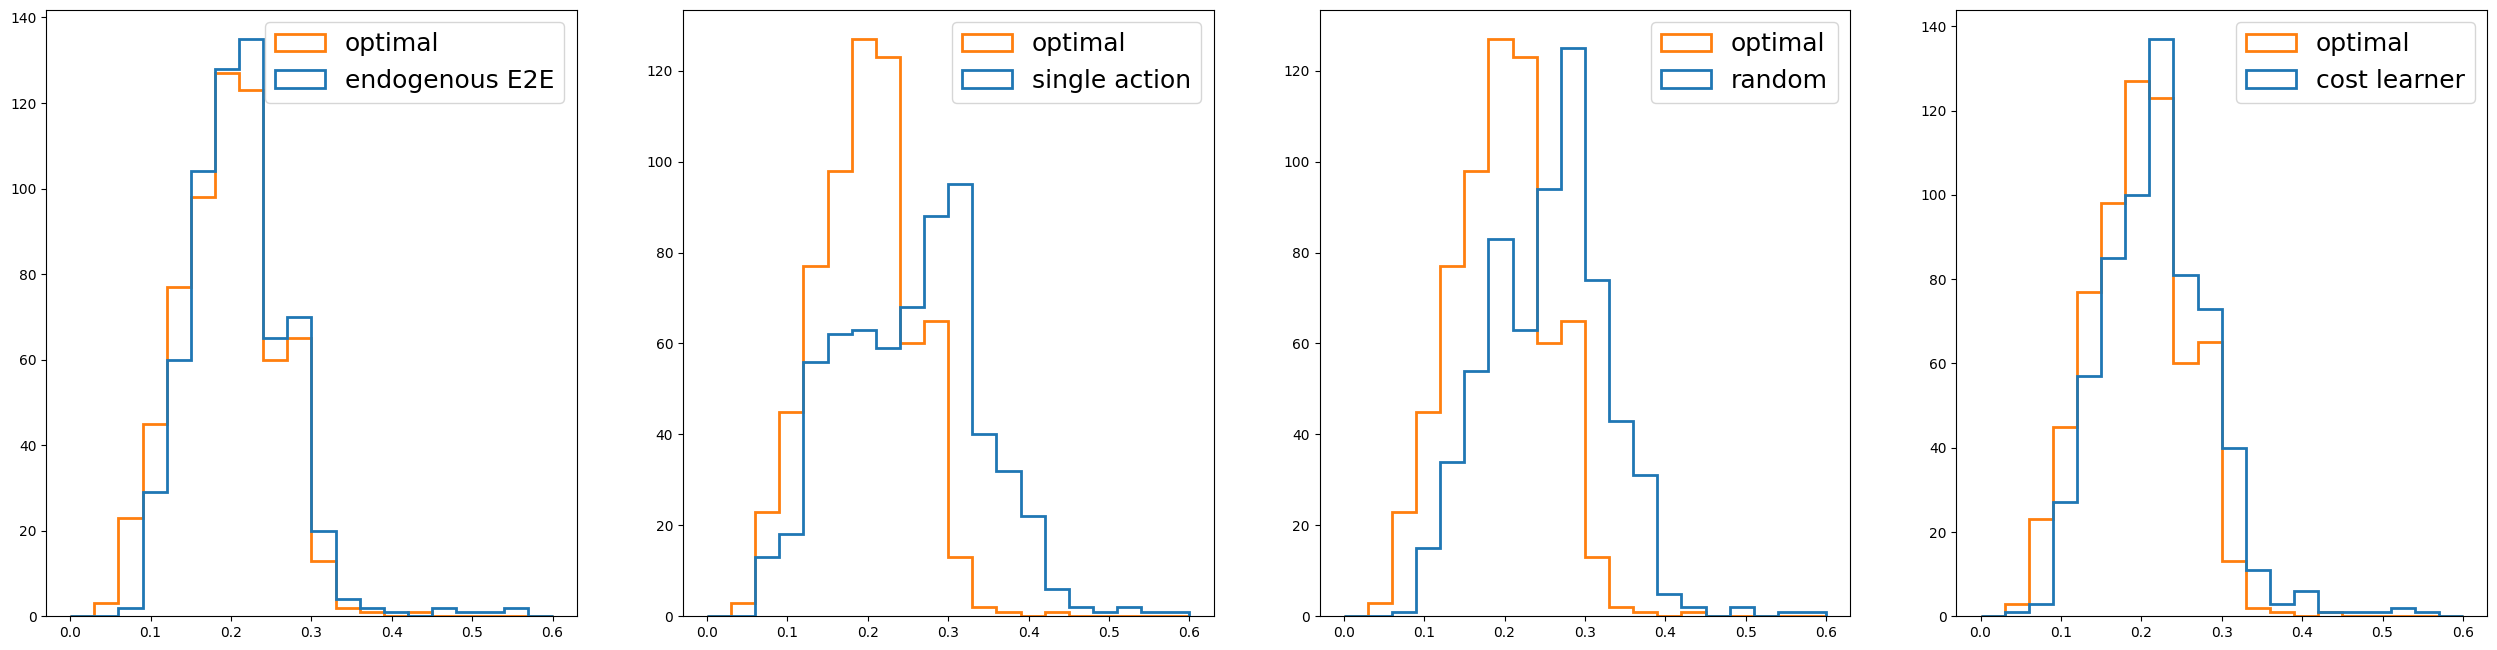

In [145]:
import matplotlib.pyplot as plt

bins = 20

cm = 1/2.54  # centimeters in inches
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(40*cm, 40*cm))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(80*cm, 20*cm))
ax1.hist([ours, optimal], label=['endogenous E2E', 'optimal'], bins=bins, histtype='step', range=[0, 0.6], linewidth=2.0)
ax1.legend(fontsize="18")
ax2.hist([all_costs[:,single_action], optimal], label=['single action', 'optimal'], bins=bins, histtype='step', range=[0,0.6], linewidth=2.0)
ax2.legend(fontsize="18")
ax3.hist([random, optimal], label=['random', 'optimal'], bins=bins, histtype='step', range=[0,0.6], linewidth=2.0)
ax3.legend(fontsize="18")
ax4.hist([reward_losses, optimal], label=['cost learner', 'optimal'], bins=bins, histtype='step', range=[0,0.6], linewidth=2.0)
ax4.legend(fontsize="18")
plt.savefig('cost_distribution_long.png')


(array([  2.,  91., 126.,   4.,  35.,  56., 136.,   0.,   9.,   0., 110.,
          0.,   0.,   1.,   1.,   0.,   6.,   0.,  56.,   3.,   1.,   1.,
          0.,   1.]),
 array([ 1.   ,  1.875,  2.75 ,  3.625,  4.5  ,  5.375,  6.25 ,  7.125,
         8.   ,  8.875,  9.75 , 10.625, 11.5  , 12.375, 13.25 , 14.125,
        15.   , 15.875, 16.75 , 17.625, 18.5  , 19.375, 20.25 , 21.125,
        22.   ]),
 <BarContainer object of 24 artists>)

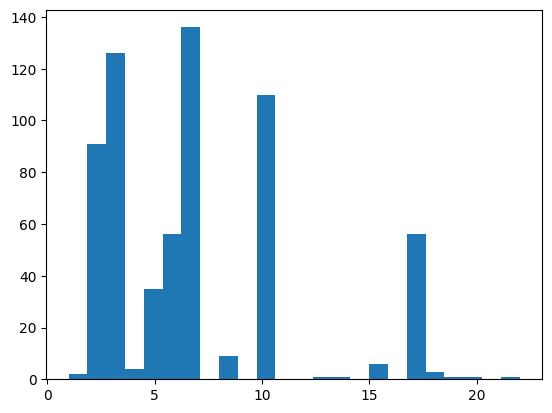

In [83]:
plt.hist(reward_actions,bins=24)

(array([ 16.,  34., 182., 127.,  76.,  10.,   1.,   8.,  13.,   0.,   2.,
          0.,   0.,   2.,  15.,  30.,  77.,   4.,   2.,   6.,   0.,  10.,
         17.,   7.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        , 12.91666667, 13.83333333,
        14.75      , 15.66666667, 16.58333333, 17.5       , 18.41666667,
        19.33333333, 20.25      , 21.16666667, 22.08333333, 23.        ]),
 <BarContainer object of 24 artists>)

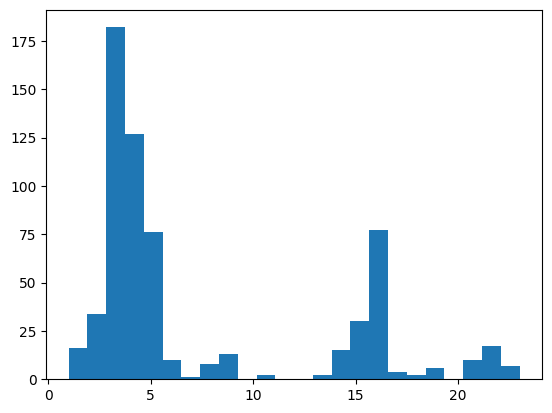

In [84]:
plt.hist(my_decisions,bins=24)

In [51]:
all_costs = np.array(all_costs)

In [255]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(24)], y=, mode='lines', name='data', marker=dict(color='green')))
fig.update_layout(xaxis_title='alpha', yaxis_title='Loss', title='Loss at w = 0.25, g(w,z)=1', width = 600, height = 600)
